#Import libraries

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset

import torch.optim as optim

import torchvision.transforms as transforms

from torchvision import datasets

import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import accuracy_score

from torch.utils.tensorboard import SummaryWriter

#set configuration and parameters

In [11]:
batch_size = 32
num_workers = 2
n_epochs = 10
gpu = True

lr = 1e-3

#Load data and create dataloader

In [7]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

trainset = datasets.CIFAR10(root = 'data', train = True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size = batch_size, num_workers=num_workers, shuffle = True, drop_last=True)

testset = datasets.CIFAR10(root = 'data', train = False, download=True, transform = transform)
testloader = DataLoader(testset, batch_size = batch_size, num_workers = num_workers, shuffle = True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


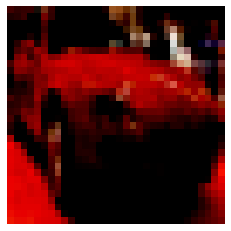

In [8]:
#visualize an image sample

image, _ = trainset.__getitem__(5)
image = image.permute(1, 2, 0).numpy()

plt.imshow(image)
plt.axis('off')

plt.show()

#Define Model

In [9]:
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 5)

    self.act = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.linear1 = nn.Linear(in_features = 5 * 5 * 16, out_features = 128)
    self.linear2 = nn.Linear(in_features = 128, out_features = 64)
    self.linear3 = nn.Linear(in_features = 64, out_features = 10)

    self.dropout1 = nn.Dropout(p = 0.7)
    self.dropout2 = nn.Dropout(p = 0.4)

  def forward(self, x):
    x = self.conv1(x)
    x = self.act(x)
    x = self.maxpool(x)

    x = self.conv2(x)
    x = self.act(x)
    x = self.maxpool(x)

    x = nn.Flatten()(x)

    x = self.linear1(x)
    x = self.dropout1(x)
    x = self.linear2(x)
    x = self.dropout2(x)
    x = self.linear3(x)

    return x


In [12]:
device = torch.device('cuda:0' if gpu else 'cpu')

model = Classifier().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr = lr)


writer = SummaryWriter("runs/test")

best_loss = np.inf
for e in range(n_epochs):
  model.train()
  epoch_loss = 0
  for i, data in enumerate(trainloader):
    image, labels = data
    image = image.to(device)
    labels = labels.to(device)
    o = model(image)

    loss = criterion(o, labels)

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    epoch_loss += loss.item()
   
  print('Epoch {}/{}-Loss:{}'.format(e + 1, n_epochs, epoch_loss /i))
  model.eval()
  test_loss = 0
  with torch.no_grad():
    for i, data in enumerate(testloader):
      image, labels = data
      image = image.to(device)
      labels = labels.to(device)
      o = model(image)

      loss = criterion(o, labels)

      test_loss += loss.item()
    
    print('Test loss ---- Epoch {}/{}-Loss:{}'.format(e + 1, n_epochs, test_loss /i))

    writer.add_scalar("Loss/train", epoch_loss, e)
    writer.add_scalar("Loss/test", test_loss, e)
    if test_loss < best_loss:
      torch.save(model.state_dict(), 'checkpoint.pt')
      best_loss = test_loss
 




Epoch 1/10-Loss:1.6801760044714948
Test loss ---- Epoch 1/10-Loss:1.400604600325609
Epoch 2/10-Loss:1.4360939980622365
Test loss ---- Epoch 2/10-Loss:1.2946806913002944
Epoch 3/10-Loss:1.3392092624892797
Test loss ---- Epoch 3/10-Loss:1.2262451639160132
Epoch 4/10-Loss:1.2757876447803465


KeyboardInterrupt: ignored

#Loading and testing the model

In [ ]:
model = Classifier().to(device)
model.load_state_dict(torch.load('checkpoint.pt'))

<All keys matched successfully>

In [ ]:
model.eval()

labels_total = []
preds_total = []
for i, data in enumerate(testloader):
  image, labels = data
  image = image.to(device)
  labels = labels.to(device)
  o = model(image)
  preds = torch.max(o, dim = 1)[1]
  labels_total.append(labels.cpu().numpy())
  preds_total.append(preds.cpu().numpy())


preds_total = np.concatenate(preds_total)
labels_total = np.concatenate(labels_total)

print(accuracy_score(labels_total, preds_total))

0.6674


In [14]:
!zip -r runs.zip runs

  adding: runs/ (stored 0%)
  adding: runs/test/ (stored 0%)
  adding: runs/test/events.out.tfevents.1643184615.67cb53567f67.78.1 (deflated 40%)
  adding: runs/test/events.out.tfevents.1643184503.67cb53567f67.78.0 (deflated 5%)
